Files already downloaded and verified
Starting Training on GPU with FP16 Optimization...

[1/10] [0/157] Loss_D: 1.3465 | Loss_G: 2.8248
[1/10] [50/157] Loss_D: 0.4822 | Loss_G: 16.9445
[1/10] [100/157] Loss_D: 0.2716 | Loss_G: 3.6955
[1/10] [150/157] Loss_D: 0.5328 | Loss_G: 3.6283
[2/10] [0/157] Loss_D: 0.4271 | Loss_G: 4.4917
[2/10] [50/157] Loss_D: 1.0489 | Loss_G: 2.2404
[2/10] [100/157] Loss_D: 0.6477 | Loss_G: 4.0370
[2/10] [150/157] Loss_D: 0.7625 | Loss_G: 7.0069
[3/10] [0/157] Loss_D: 0.5955 | Loss_G: 4.8147
[3/10] [50/157] Loss_D: 0.6855 | Loss_G: 1.4116
[3/10] [100/157] Loss_D: 0.6159 | Loss_G: 5.4214
[3/10] [150/157] Loss_D: 0.7677 | Loss_G: 6.5205
[4/10] [0/157] Loss_D: 0.4098 | Loss_G: 3.0245
[4/10] [50/157] Loss_D: 0.5102 | Loss_G: 3.6747
[4/10] [100/157] Loss_D: 0.3911 | Loss_G: 3.1797
[4/10] [150/157] Loss_D: 0.5431 | Loss_G: 5.5186
[5/10] [0/157] Loss_D: 0.4798 | Loss_G: 3.6273
[5/10] [50/157] Loss_D: 0.2720 | Loss_G: 4.0797
[5/10] [100/157] Loss_D: 0.5716 | Loss_G: 

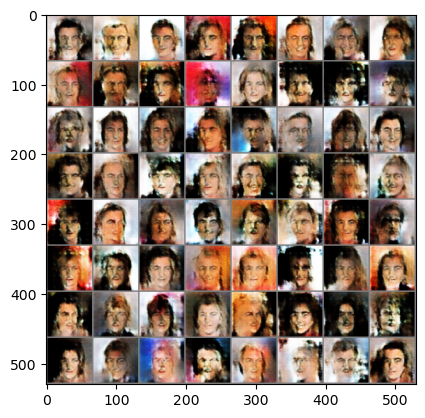

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import time

# Ensure we use GPU and enable Tensor Cores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable AMP (Automatic Mixed Precision) for FP16 Optimization
scaler = torch.cuda.amp.GradScaler()

# Function to visualize generated images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Generator (Optimized for FP16)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator (Optimized for FP16)
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)  # No Sigmoid; handled by BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.main(x).view(-1)

# Hyperparameters
nz = 100      # Size of latent vector
ngf = 64      # Generator feature maps
ndf = 64      # Discriminator feature maps
nc = 3        # RGB images for CelebA
lr = 0.0002
beta1 = 0.5
batch_size = 64  
epochs = 10

# Create Generator and Discriminator
netG = Generator(nz, ngf, nc).to(device).to(memory_format=torch.channels_last)
netD = Discriminator(nc, ndf).to(device).to(memory_format=torch.channels_last)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()  # More stable with FP16
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Data loading and preprocessing for CelebA
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=transform)
indices = torch.randperm(len(dataset))[:10000]  # Optionally, use a subset for quicker training
dataset = Subset(dataset, indices)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Start Timing
start_time = time.time()

# Training loop
print("Starting Training on GPU with FP16 Optimization...\n")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device, memory_format=torch.channels_last)
        batch_size_current = real_images.size(0)
        noise = torch.randn(batch_size_current, nz, 1, 1, device=device)

        # Train Discriminator with FP16
        netD.zero_grad()
        with torch.cuda.amp.autocast():
            real_labels = torch.ones(batch_size_current, device=device)
            real_output = netD(real_images)
            real_loss = criterion(real_output, real_labels)

            fake_images = netG(noise)
            fake_labels = torch.zeros(batch_size_current, device=device)
            fake_output = netD(fake_images.detach())
            fake_loss = criterion(fake_output, fake_labels)

            D_loss = real_loss + fake_loss

        scaler.scale(D_loss).backward()
        scaler.step(optimizerD)
        scaler.update()

        # Train Generator with FP16
        netG.zero_grad()
        with torch.cuda.amp.autocast():
            G_labels = torch.ones(batch_size_current, device=device)
            G_output = netD(fake_images)
            G_loss = criterion(G_output, G_labels)

        scaler.scale(G_loss).backward()
        scaler.step(optimizerG)
        scaler.update()

        # Print progress
        if i % 50 == 0:
            print(f"[{epoch+1}/{epochs}] [{i}/{len(dataloader)}] Loss_D: {D_loss.item():.4f} | Loss_G: {G_loss.item():.4f}")

# End Timing
end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time):.2f} seconds.")

# Generate images after training
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()

# Visualize the generated images
generated_grid = torchvision.utils.make_grid(fake_images[:64], nrow=8, padding=2)
imshow(generated_grid)

# Save trained models
torch.save(netG.state_dict(), "dcgan_generator_fp16_celeba.pth")
torch.save(netD.state_dict(), "dcgan_discriminator_fp16_celeba.pth")
